In [40]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [41]:
dl = tfds.load('mnist', shuffle_files=True)

In [42]:
ds = dl['train']

In [43]:
dataiter = ds.as_numpy_iterator()

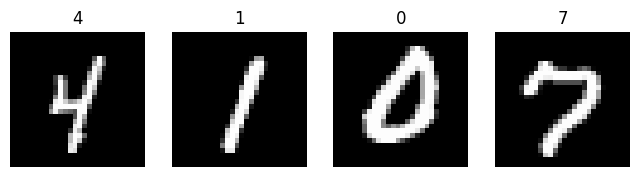

In [44]:
fig, axs = plt.subplots(ncols=4, figsize=(8, 8))
for idx in range(4):
  batch = dataiter.next()
  axs[idx].imshow(np.squeeze(batch['image']), 'gray')
  axs[idx].set_title(batch['label'])
  axs[idx].axis('off')

In [45]:
def process(image_data):
  img = image_data['image']
  return img / 255

In [46]:
BATCH_SIZE = 128

In [47]:
ds = ds.map(process)
ds = ds.cache()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(64)

In [48]:
np.squeeze(ds.as_numpy_iterator().next()).shape

(128, 28, 28)

In [49]:
from keras.layers import Conv2D, Dense, LeakyReLU, UpSampling2D, Dropout, Reshape, Flatten
from keras.models import Sequential

In [50]:
def build_generator():
  model = Sequential([
      Dense(7*7*128, input_dim=128),
      LeakyReLU(0.2),
      Reshape((7, 7, 128)),

      UpSampling2D(),
      Conv2D(128, 5, padding='same'),
      LeakyReLU(0.2),

      UpSampling2D(),
      Conv2D(128, 5, padding='same'),
      LeakyReLU(0.2),

      Conv2D(128, 3, padding='same'),
      LeakyReLU(0.2),

      Conv2D(64, 3, padding='same'),
      LeakyReLU(0.2),

      Conv2D(1, 3, padding='same', activation = 'sigmoid')
  ])

  return model

In [51]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [52]:
img = generator(np.random.randn(4, 128, 1))
img.shape

TensorShape([4, 28, 28, 1])

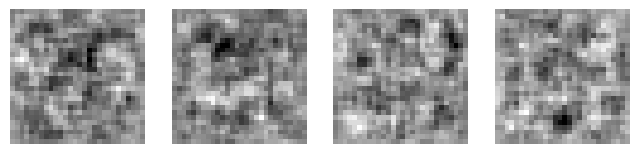

In [53]:
fig, axs = plt.subplots(ncols=4, figsize=(8, 8))
for idx, im in enumerate(img):
  axs[idx].imshow(im, 'gray')
  axs[idx].axis('off')

In [54]:
def build_discriminator():
  model = Sequential([
      Conv2D(32, 5, input_shape=(28, 28, 1)),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(64, 5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(128, 5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(256, 5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Flatten(),
      Dense(1, activation='sigmoid')
  ])

  return model

In [55]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [56]:
iter = ds.as_numpy_iterator()

In [57]:
img = iter.next()
img = img[0]

(-0.5, 27.5, 27.5, -0.5)

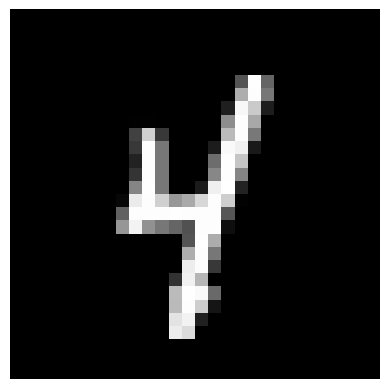

In [58]:
plt.imshow(img, 'gray')
plt.axis('off')

In [59]:
discriminator(np.expand_dims(img, 0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5014325]], dtype=float32)>

In [60]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

In [61]:
g_loss, d_loss = BinaryCrossentropy(), BinaryCrossentropy()
g_opt, d_opt = Adam(learning_rate=0.0001), Adam(learning_rate=0.0001)

In [62]:
class DCGAN(keras.Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    real_img = batch
    fake_img = self.generator(tf.random.normal((128, 128, 1)), training=False)

    with tf.GradientTape() as disc_tape:
      yhat_real = self.discriminator(real_img, training=True)
      yhat_fake = self.discriminator(fake_img, training=True)

      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
      y = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      noisy_real = 0.2 * tf.random.uniform(tf.shape(yhat_real))
      noisy_fake = -0.2 * tf.random.uniform(tf.shape(yhat_fake))
      y += tf.concat([noisy_real, noisy_fake], axis = 0)
      # print(y)

      disc_loss = self.d_loss(y, yhat_realfake)

    d_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
      gen_imgs = generator(tf.random.normal((BATCH_SIZE, 128, 1)), training=True)
      yhat_fake = discriminator(gen_imgs, training=False)
      y_real = tf.zeros_like(yhat_fake)
      gen_loss = self.g_loss(y_real, yhat_fake)

    g_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))

    return {'d_loss': disc_loss, 'g_loss': gen_loss}

In [63]:
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [64]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [65]:
class Monitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      gen_imgs = self.model.generator(tf.random.normal((self.num_img, self.latent_dim, 1)))
      gen_imgs *= 255
      gen_imgs.numpy()

      for i in range(self.num_img):
        img = array_to_img(gen_imgs[i])
        img.save(os.path.join('images', f'{epoch}_{i}.png'))

In [66]:
mnistGan = DCGAN(generator, discriminator)
mnistGan.compile(g_opt, d_opt, g_loss, d_loss)

In [67]:
EPOCHS = 30

In [68]:
with tf.device('/device:GPU:0'):
  history = mnistGan.fit(ds, epochs=EPOCHS, callbacks=[Monitor()])

Epoch 1/30
469/469 [==============================] - 71s 141ms/step - d_loss: 0.3471 - g_loss: 2.1621
Epoch 2/30
469/469 [==============================] - 66s 140ms/step - d_loss: 0.3255 - g_loss: 2.3430
Epoch 3/30
469/469 [==============================] - 66s 140ms/step - d_loss: 0.3260 - g_loss: 2.3575
Epoch 4/30
469/469 [==============================] - 66s 140ms/step - d_loss: 0.3255 - g_loss: 2.3516
Epoch 5/30
469/469 [==============================] - 65s 139ms/step - d_loss: 0.3257 - g_loss: 2.3422
Epoch 6/30
469/469 [==============================] - 65s 140ms/step - d_loss: 0.3924 - g_loss: 2.1609
Epoch 7/30
469/469 [==============================] - 66s 140ms/step - d_loss: 0.5268 - g_loss: 1.1906
Epoch 8/30
469/469 [==============================] - 66s 140ms/step - d_loss: 0.5787 - g_loss: 1.1729
Epoch 9/30
469/469 [==============================] - 66s 140ms/step - d_loss: 0.6137 - g_loss: 0.9527
Epoch 10/30
469/469 [==============================] - 66s 140ms/step - d

In [69]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


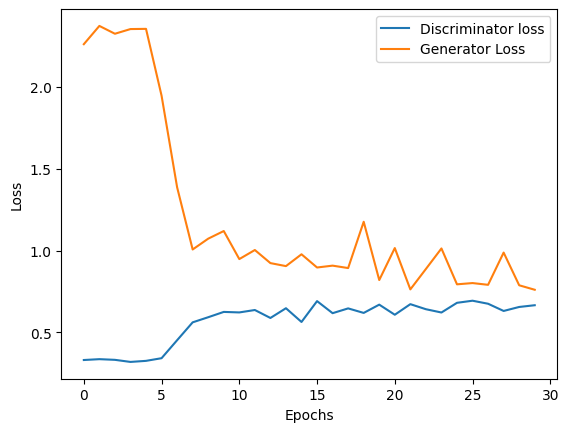

In [70]:
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend(['Discriminator loss', 'Generator Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [81]:
img = generator.predict(np.random.randn(6, 128, 1))
img.shape

1/1 [==============================] - 0s 35ms/step


(6, 28, 28, 1)

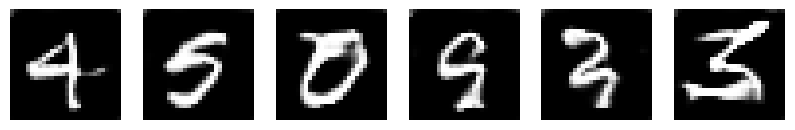

In [82]:
fig, axs = plt.subplots(ncols=6, figsize=(10, 10))
for idx, im in enumerate(img):
  axs[idx].imshow(im, 'gray')
  axs[idx].axis('off')